In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import time
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torchvision.transforms.functional as F
import timm
import pandas as pd

# 🚨 IMPORTANT: Enable Internet in Kaggle

**Before running this notebook on Kaggle:**

1. Go to **Settings** (right sidebar)
2. Scroll to **Internet** section
3. Toggle **Internet ON** ✅
4. This allows downloading pre-trained ViT weights from Hugging Face

**Why?** The ViT model needs to download ~330MB of pre-trained weights for transfer learning.

**Alternative:** If you can't enable internet, the notebook will train from scratch (longer training time, lower accuracy initially).

---

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Kaggle dataset path (change this if running locally)
data_dir = '/kaggle/input/dataset/data'  # For Kaggle
# data_dir = '../../data'  # Uncomment for local use

print(f"Using device: {device}")
print(f"Dataset directory: {data_dir}")

# Check GPU availability and specifications
if torch.cuda.is_available():
    print(f"GPU Count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")

In [ ]:
# Verify dataset structure
import os

print("Dataset Structure Verification:")
print("="*50)

for split in ['train', 'val', 'test']:
    split_path = os.path.join(data_dir, split)
    if os.path.exists(split_path):
        classes = sorted(os.listdir(split_path))
        print(f"\n{split.upper()} folder:")
        print(f"  Classes found: {classes}")
        print(f"  Number of classes: {len(classes)}")
        
        # Count images in each class
        for cls in classes:
            cls_path = os.path.join(split_path, cls)
            if os.path.isdir(cls_path):
                num_images = len([f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
                print(f"    {cls}: {num_images} images")
    else:
        print(f"\n⚠️ {split.upper()} folder not found at {split_path}")

print("\n" + "="*50)
print("✅ Expected classes: ['algae', 'major_crack', 'minor_crack', 'peeling', 'plain', 'spalling', 'stain']")

In [19]:
# Model name
model_name = "vit_base_patch16_224"

In [ ]:
# Number of classes
num_classes = 7
 
# Batch size - OPTIMIZED for T4 x2 (increased from 16 to 48)
batch_size = 48  # Increased for better GPU utilization
 
# Number of epochs
num_epochs = 200
 
# Flag for feature extracting
feature_extract = False

# Enable mixed precision training for faster computation
use_amp = True  # Automatic Mixed Precision

print(f"Batch Size: {batch_size}")
print(f"Mixed Precision (AMP): {use_amp}")

In [21]:

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
 

In [ ]:
# Load datasets with optimized data loading
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

# OPTIMIZED: Increased num_workers and enabled pin_memory for faster data loading
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=batch_size, 
        shuffle=(x == 'train'),  # Only shuffle training data
        num_workers=12,  # Increased from 8 to 12 for maximum CPU utilization
        pin_memory=True,  # Faster data transfer to GPU
        persistent_workers=True,  # Keep workers alive between epochs
        prefetch_factor=4  # Prefetch 4 batches per worker for faster loading
    ) for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Classes: {class_names}")

## train

In [23]:
# Initialize the model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
 
    if model_name == "vit_base_patch16_224":
        model_ft = timm.create_model('vit_base_patch16_224', pretrained=use_pretrained, num_classes=num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()
 
    return model_ft, input_size

In [ ]:
# Initialize model with offline mode for Kaggle
import os

# For Kaggle: Need to enable internet or use offline mode
if os.path.exists('/kaggle/input'):
    # Kaggle environment - use offline mode if pretrained weights available
    try:
        model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    except Exception as e:
        print(f"⚠️ Could not download pretrained weights: {e}")
        print("📥 Switching to random initialization (no pretrained weights)")
        model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)
else:
    # Local environment
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)

# OPTIMIZED: Use DataParallel for multi-GPU training (T4 x2)
if torch.cuda.device_count() > 1:
    print(f"🚀 Using {torch.cuda.device_count()} GPUs with DataParallel!")
    model_ft = nn.DataParallel(model_ft)
    
print(f"✅ Model initialized on {device}")
print(f"Model parameters: {sum(p.numel() for p in model_ft.parameters()):,}")

In [25]:
# Set parameter requires grad
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [26]:
set_parameter_requires_grad(model_ft, feature_extract)

In [27]:
# Gather the parameters to be optimized/updated in this run
params_to_update = model_ft.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)

In [ ]:
# Observe that all parameters are being optimized
# OPTIMIZED: Use AdamW optimizer for faster convergence than SGD
optimizer_ft = optim.AdamW(params_to_update, lr=0.0001, weight_decay=0.01)

# Setup the loss function
criterion = nn.CrossEntropyLoss()

# OPTIMIZED: Add gradient scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler() if use_amp else None

print(f"Optimizer: AdamW (lr=0.0001, weight_decay=0.01)")
print(f"Loss: CrossEntropyLoss")
print(f"Mixed Precision: {'Enabled' if use_amp else 'Disabled'}")

In [ ]:
# Training the model - OPTIMIZED with Mixed Precision Training
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, use_amp=True):
    since = time.time()
 
    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
 
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Initialize gradient scaler for mixed precision
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)  # Faster transfer
                labels = labels.to(device, non_blocking=True)
 
                optimizer.zero_grad(set_to_none=True)  # Faster than zero_grad()
 
                # OPTIMIZED: Mixed precision training
                with torch.set_grad_enabled(phase == 'train'):
                    if use_amp and phase == 'train':
                        # Use automatic mixed precision for training
                        with torch.cuda.amp.autocast():
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                        
                        _, preds = torch.max(outputs, 1)
                        
                        # Backward pass with gradient scaling
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        # Standard precision for validation
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
 
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        
        # Clear cache to prevent memory issues
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
 
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

In [ ]:
# Train and evaluate - OPTIMIZED with mixed precision
model_ft, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = train_model(
    model_ft, 
    dataloaders, 
    criterion, 
    optimizer_ft, 
    num_epochs=num_epochs,
    use_amp=use_amp  # Enable mixed precision
)

In [ ]:
# ============================================
# SAVE MODEL WEIGHTS - KAGGLE COMPATIBLE
# ============================================
import os

model_name = 'vit'
save_path = f'{model_name}_weights.pth'

# Save model state dict
torch.save(model_ft.state_dict(), save_path)

# For Kaggle: Copy to /kaggle/working/ for easy download
if os.path.exists('/kaggle/working'):
    kaggle_path = f'/kaggle/working/{save_path}'
    torch.save(model_ft.state_dict(), kaggle_path)
    print(f"✅ Model saved for Kaggle download: {kaggle_path}")
else:
    print(f"✅ Model saved locally: {save_path}")

# Verification
file_size_mb = os.path.getsize(save_path) / (1024 * 1024)
print(f"📁 File: {save_path}")
print(f"💾 Size: {file_size_mb:.2f} MB")
print(f"📍 Location: {os.path.abspath(save_path)}")
print("\n🎉 Training complete! Download .pth file from Output tab (if on Kaggle)")

In [1]:
train_acc_hist = torch.tensor(train_acc_hist)
val_acc_hist = torch.tensor(val_acc_hist)
train_loss_hist = torch.tensor(train_loss_hist)
val_loss_hist = torch.tensor(val_loss_hist)

train_acc_hist = train_acc_hist.cpu()
val_acc_hist = val_acc_hist.cpu()
train_loss_hist = train_loss_hist.cpu()
val_loss_hist = val_loss_hist.cpu()

In [157]:
# Plot training and validation accuracy and loss
def plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs):
    epochs = range(1, num_epochs + 1)
 
    plt.figure(figsize=(14, 5))
 
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_hist, label='Training Accuracy')
    plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
 
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss_hist, label='Training Loss')
    plt.plot(epochs, val_loss_hist, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
 
plt.show()

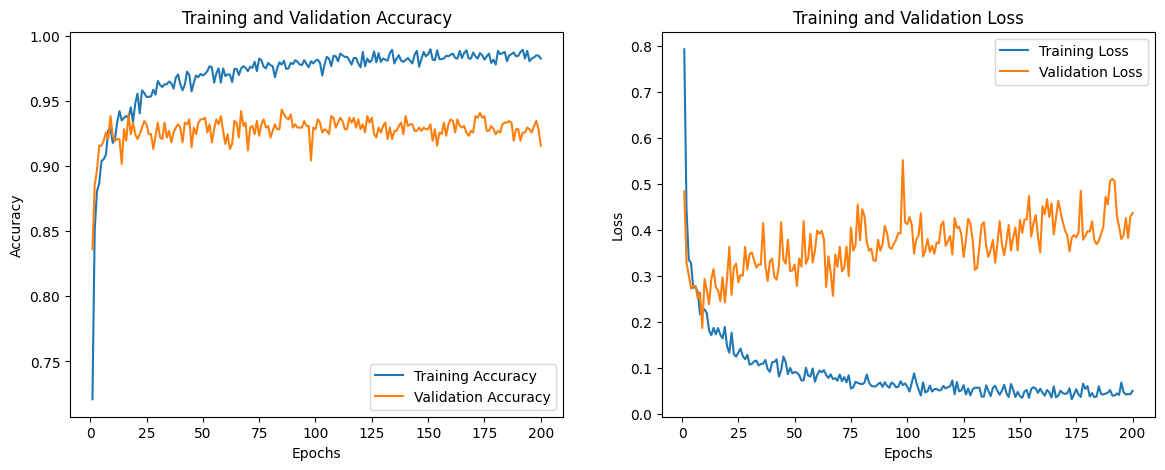

In [158]:
# Call the plot function
plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs)
 

## eval

In [32]:
# Evaluate the model on test data
model_ft.eval()
test_corrects = 0
all_preds = []
all_labels = []
 
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
 
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
 
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    test_corrects += torch.sum(preds == labels.data)
 
test_acc = test_corrects.double() / dataset_sizes['test']
print('Test Accuracy: {:.4f}'.format(test_acc))
 

Test Accuracy: 0.0972


In [34]:
class_names

['algae',
 'major_crack',
 'minor_crack',
 'peeling',
 'plain',
 'spalling',
 'stain']

In [33]:
# Generate confusion matrix and classification report
conf_mat = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Confusion Matrix:
 [[10  0 27 13 14 58  2]
 [46  2  1 18 15 34  0]
 [27 10  5  8 28 46  0]
 [23  5  3  6 20 44  3]
 [58 14 12 10 11 13  2]
 [16  2  8 21  7 42  4]
 [28  5 10 26 19 15  1]]
Classification Report:
               precision    recall  f1-score   support

       algae       0.05      0.08      0.06       124
 major_crack       0.05      0.02      0.03       116
 minor_crack       0.08      0.04      0.05       124
     peeling       0.06      0.06      0.06       104
       plain       0.10      0.09      0.09       120
    spalling       0.17      0.42      0.24       100
       stain       0.08      0.01      0.02       104

    accuracy                           0.10       792
   macro avg       0.08      0.10      0.08       792
weighted avg       0.08      0.10      0.08       792



In [ ]:
# Convert the labels and predictions to their corresponding class names
actual_class_names = [class_names[label] for label in all_labels]
predicted_class_names = [class_names[pred] for pred in all_preds]

# Create the DataFrame
res = pd.DataFrame({"actual": actual_class_names, "predicted": predicted_class_names})

print(res)

# Save results CSV
csv_filename = 'vit_results.csv'
res.to_csv(csv_filename, index=False)

# For Kaggle: Also save to /kaggle/working/
if os.path.exists('/kaggle/working'):
    kaggle_csv = f'/kaggle/working/{csv_filename}'
    res.to_csv(kaggle_csv, index=False)
    print(f"✅ Results saved for Kaggle: {kaggle_csv}")
else:
    print(f"✅ Results saved locally: {csv_filename}")

          actual    predicted
0    major_crack  major_crack
1          stain        stain
2    major_crack  major_crack
3          algae        algae
4       spalling     spalling
..           ...          ...
787        algae        algae
788  minor_crack  minor_crack
789        stain        stain
790      peeling      peeling
791     spalling     spalling

[792 rows x 2 columns]


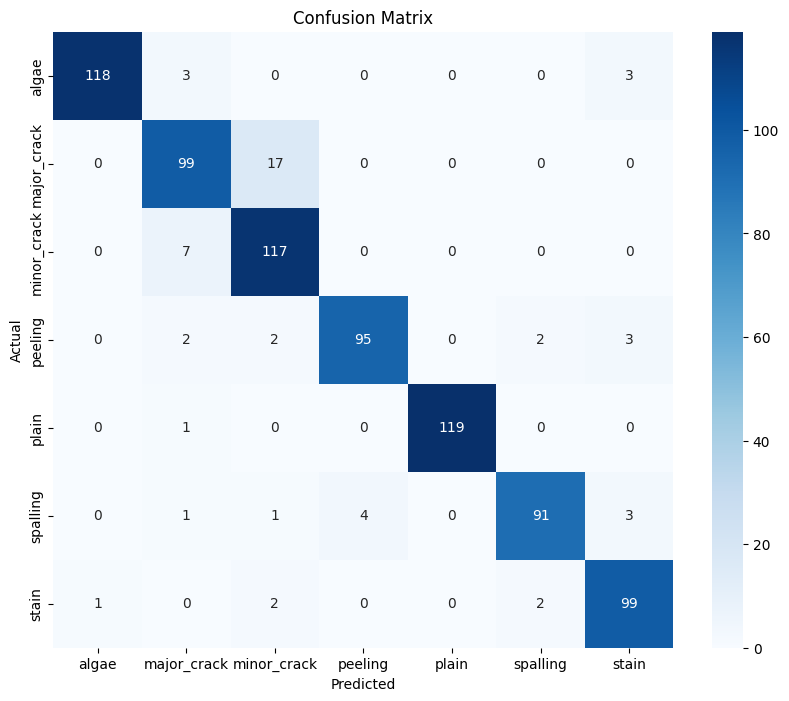

In [162]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('curat_vt_confusion_matrix.png')
plt.show()


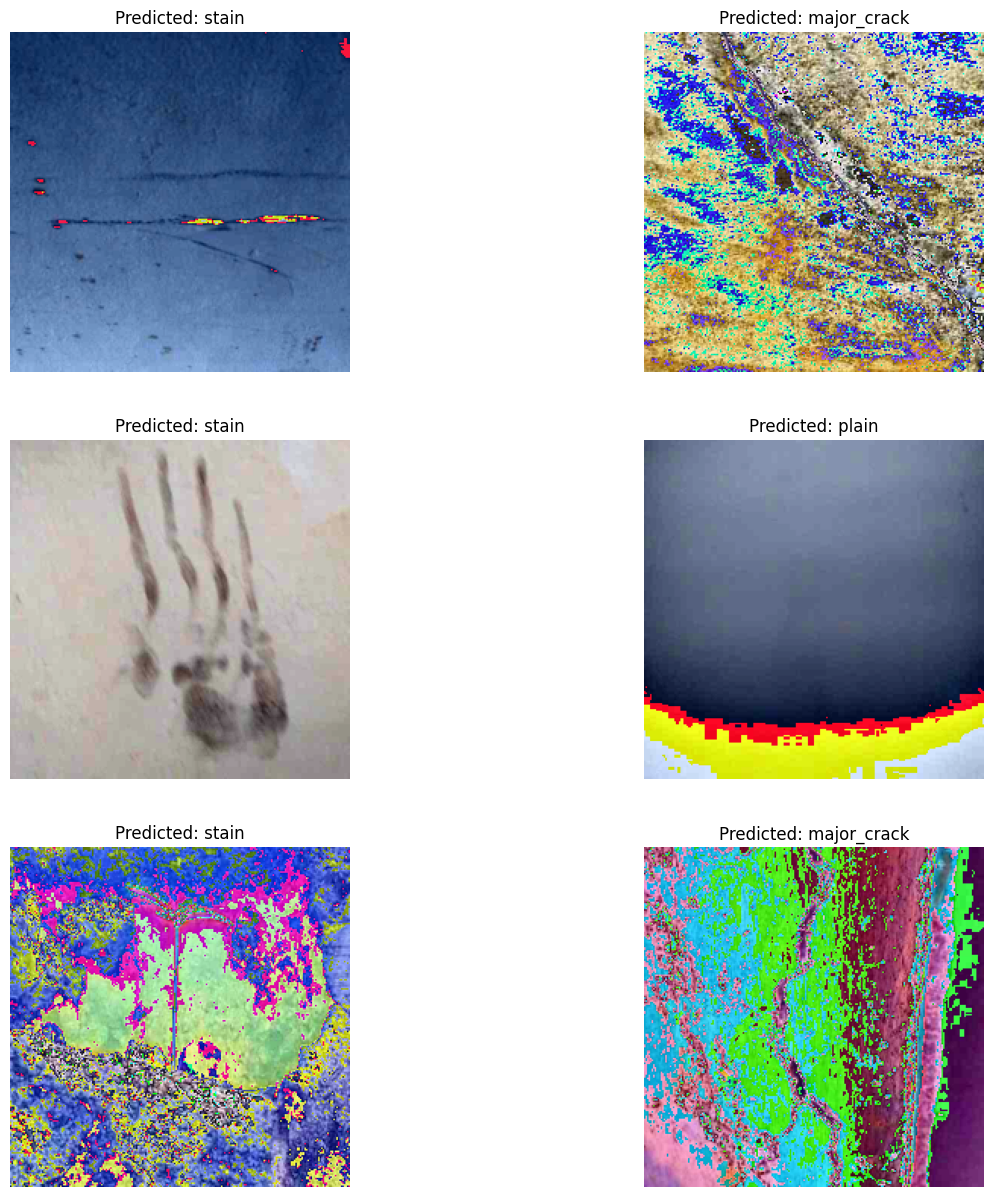

In [163]:

# Function to visualize predictions
def visualize_predictions(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))
 
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
 
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                plt.imshow(F.to_pil_image(inputs.cpu().data[j]))
 
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
 
# Visualize predictions
visualize_predictions(model_ft, dataloaders, class_names, num_images=6)

In [164]:
# Compute and display evaluation metrics
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
 
accuracy = np.mean(y_true == y_pred)
precision = np.diag(conf_mat) / np.sum(conf_mat, axis=0)
recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
f1_score = 2 * precision * recall / (precision + recall)
 
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print the average precision, recall, and F1-score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f}")
 
# Ensure the confusion matrix and the classification report are saved
with open('curat_vt_classification_report.txt', 'w') as f:
    f.write(f"Classification Report:\n{class_report}\n")

Accuracy: 0.9318
Average Precision: 0.9348
Average Recall: 0.9308
Average F1-Score: 0.9321


In [9]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)


In [10]:
model_ft.load_state_dict(torch.load('nn-vt-org-weights.pth'))

<All keys matched successfully>

In [12]:
print(inputs.device) 

cuda:0


In [2]:
# Load the model
model_ft.eval()
model_ft.to(device)
# Create the attention folder if it doesn't exist
attention_dir = os.path.join(data_dir, 'attention')
os.makedirs(attention_dir, exist_ok=True)

# Iterate through the test dataset
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass through the model
    outputs = model_ft(inputs)

    # Get the attention map
    attention_map = model_ft.get_attention_map(inputs)

    # Save the attention map
    for i, img in enumerate(inputs):
        attention_img = F.to_pil_image(attention_map[i])
        attention_img.save(os.path.join(attention_dir, f'test_image_{i}.png'))
